**Libraries/Imports**

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MultiLabelBinarizer
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, precision_score, f1_score, confusion_matrix, precision_recall_fscore_support
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier,  plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold


**Data Preprocessing**

In [21]:
# Reading in raw Pokemon Database.csv
raw = pd.read_csv('Pokemon Database.csv')

# Cleaning string values
for index, pokemon in raw.iterrows():
    for column in raw.columns:
        if isinstance(pokemon[column], str):
            raw.at[index, column] = pokemon[column][1:-1]

# Converting Alternate Form Name to Correct Names
raw["Alternate Form Name"] = raw["Alternate Form Name"].replace({
    "Hisui": "Hisuian",
    "Alola": "Alolan",
    "Galar": "Galarian"
})    

# Updating Pokemon Names and Handling Missing Values
for index, pokemon in raw.iterrows():
    if pd.isna(pokemon['Legendary Type']):
        raw.at[index, "Legendary Type"] = "Regular"
    if pd.isna(pokemon["Secondary Type"]):
        raw.at[index, "Secondary Type"] = pokemon["Primary Type"]     
    alternate_form = pokemon['Alternate Form Name']
    if not pd.isna(alternate_form) and isinstance(alternate_form, str):
        if alternate_form in ["Mega X", "Mega Y"]:
            raw.at[index, "Pokemon Name"] = f"Mega {raw.at[index, 'Pokemon Name']} {alternate_form[-1]}"
        elif pokemon["Pokemon Name"] in ["Unown", "Hoopa"]:
            raw.at[index, "Pokemon Name"] = f"{raw.at[index, 'Pokemon Name']} {alternate_form}"
        else:
            raw.at[index, "Pokemon Name"] = f"{alternate_form} {raw.at[index, 'Pokemon Name']}"

# Selecting Relevant Columns
relevant = raw[['Pokemon Id', 'Pokedex Number', 'Pokemon Name',
       'Alternate Form Name', 'Original Pokemon ID', 'Legendary Type',
       'Pokemon Height', 'Pokemon Weight', 'Primary Type', 'Secondary Type', 
       'Male Ratio', 'Female Ratio', 'Base Happiness', 'Health Stat', 'Attack Stat',
       'Defense Stat', 'Special Attack Stat', 'Special Defense Stat',
       'Speed Stat', 'Base Stat Total', 'Health EV', 'Attack EV', 'Defense EV',
       'Special Attack EV', 'Special Defense EV', 'Speed EV', 'EV Yield Total',
       'Catch Rate', 'Experience Growth', 'Experience Growth Total', 'Egg Cycle Count']]

# Remove Gigantamax Forms
relevant = relevant.loc[relevant['Alternate Form Name'] != 'Gigantamax']
relevant = relevant.reset_index()

# Define Features for Transformation
features = ['Legendary Type', 'Pokemon Height', 'Pokemon Weight', 'Primary Type', 'Secondary Type',
            'Male Ratio', 'Female Ratio', 'Base Happiness', 'Health Stat', 'Attack Stat', 'Defense Stat', 
            'Special Attack Stat', 'Special Defense Stat', 'Speed Stat', 'Base Stat Total', 'Health EV', 
            'Attack EV', 'Defense EV', 'Special Attack EV', 'Special Defense EV', 'Speed EV', 
            'EV Yield Total', 'Catch Rate', 'Experience Growth', 'Experience Growth Total', 'Egg Cycle Count'] 

# Define Numerical Features
numerical_features = [col for col in features if col not in ['Legendary Type', 'Experience Growth', 'Primary Type', 'Secondary Type']]

# Apply Label Encoding to Typings (For Classification)
label_encoder_primary = LabelEncoder()
label_encoder_secondary = LabelEncoder()

relevant['Primary Typing Label'] = label_encoder_primary.fit_transform(relevant['Primary Type'])
relevant['Secondary Typing Label'] = label_encoder_secondary.fit_transform(relevant['Secondary Type'])

# Define One-Hot Encoding for Categorical Features, Scaling Values
categorical_features = ['Legendary Type', 'Experience Growth']
transformer = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),  
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  
])

# Apply Transformations
transformed = transformer.fit_transform(relevant[features])
encoded_feature_names = transformer.get_feature_names_out()

# Convert to DataFrame
processed = pd.DataFrame(transformed, columns=encoded_feature_names)

# Add Primary & Secondary Typing Labels
processed['Primary Typing Label'] = relevant['Primary Typing Label']
processed['Secondary Typing Label'] = relevant['Secondary Typing Label']

# Save Processed Data
print(processed.shape)
processed.to_csv('processed_data.csv', index=False)

(1350, 34)


**Splitting Test and Train Datasets**

In [22]:
# Defining Features and Labels Matricies
X = processed.drop(columns=['Primary Typing Label', 'Secondary Typing Label'])
y_primary = processed[['Primary Typing Label']]
y_secondary = processed[['Secondary Typing Label']]

y_svm = y_primary.values.ravel()

# Split into training and test data
X_train, X_test, y_primary_train, y_primary_test, y_secondary_train, y_secondary_test = train_test_split(X, y_primary, y_secondary, test_size=0.2, random_state=42)

**Random Guess**

In [23]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracy_list = []
macro_precision_list = []
macro_recall_list = []
macro_f1_list = []

weighted_precision_list = []
weighted_recall_list = []
weighted_f1_list = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, processed['Primary Typing Label']), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train = processed['Primary Typing Label'].iloc[train_idx]
    y_test = processed['Primary Typing Label'].iloc[test_idx]

    dummy = DummyClassifier(strategy='uniform', random_state=42)
    dummy.fit(X_train, y_train)
    y_pred = dummy.predict(X_test)


    acc = accuracy_score(y_test, y_pred)
    accuracy_list.append(acc)

    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average='macro', zero_division=0
    )
    macro_precision_list.append(macro_precision)
    macro_recall_list.append(macro_recall)
    macro_f1_list.append(macro_f1)

    weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average='weighted', zero_division=0
    )
    weighted_precision_list.append(weighted_precision)
    weighted_recall_list.append(weighted_recall)
    weighted_f1_list.append(weighted_f1)

    print(f"\nFold {fold} Accuracy: {acc:.4f}")

def mean_std(values):
    return f"{np.mean(values):.4f} ± {np.std(values):.4f}"
print("\n=== Random Guess Baseline Metrics (Mean ± Std) ===")
print(f"Accuracy:           {mean_std(accuracy_list)}")
print(f"Macro Precision:    {mean_std(macro_precision_list)}")
print(f"Macro Recall:       {mean_std(macro_recall_list)}")
print(f"Macro F1-Score:     {mean_std(macro_f1_list)}")
print(f"Weighted Precision: {mean_std(weighted_precision_list)}")
print(f"Weighted Recall:    {mean_std(weighted_recall_list)}")
print(f"Weighted F1-Score:  {mean_std(weighted_f1_list)}")



Fold 1 Accuracy: 0.0370

Fold 2 Accuracy: 0.0889

Fold 3 Accuracy: 0.0444

Fold 4 Accuracy: 0.0815

Fold 5 Accuracy: 0.0741

Fold 6 Accuracy: 0.0370

Fold 7 Accuracy: 0.0667

Fold 8 Accuracy: 0.0296

Fold 9 Accuracy: 0.0370

Fold 10 Accuracy: 0.0667

=== Random Guess Baseline Metrics (Mean ± Std) ===
Accuracy:           0.0563 ± 0.0205
Macro Precision:    0.0560 ± 0.0223
Macro Recall:       0.0560 ± 0.0193
Macro F1-Score:     0.0530 ± 0.0196
Weighted Precision: 0.0643 ± 0.0280
Weighted Recall:    0.0563 ± 0.0205
Weighted F1-Score:  0.0565 ± 0.0224


**Probabilistic Guess**

In [24]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracy_list = []
macro_precision_list = []
macro_recall_list = []
macro_f1_list = []

weighted_precision_list = []
weighted_recall_list = []
weighted_f1_list = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, processed['Primary Typing Label']), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train = processed['Primary Typing Label'].iloc[train_idx]
    y_test = processed['Primary Typing Label'].iloc[test_idx]

    prob_guess = DummyClassifier(strategy='stratified', random_state=42)
    prob_guess.fit(X_train, y_train)
    y_pred = prob_guess.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    accuracy_list.append(acc)

    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average='macro', zero_division=0
    )
    macro_precision_list.append(macro_precision)
    macro_recall_list.append(macro_recall)
    macro_f1_list.append(macro_f1)
    
    weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average='weighted', zero_division=0
    )
    weighted_precision_list.append(weighted_precision)
    weighted_recall_list.append(weighted_recall)
    weighted_f1_list.append(weighted_f1)

    print(f"\nFold {fold} Accuracy: {acc:.4f}")


def mean_std(values):
    return f"{np.mean(values):.4f} ± {np.std(values):.4f}"

print("\n=== Stratified (Probabilistic Guess) Metrics (Mean ± Std) ===")
print(f"Accuracy:           {mean_std(accuracy_list)}")
print(f"Macro Precision:    {mean_std(macro_precision_list)}")
print(f"Macro Recall:       {mean_std(macro_recall_list)}")
print(f"Macro F1-Score:     {mean_std(macro_f1_list)}")
print(f"Weighted Precision: {mean_std(weighted_precision_list)}")
print(f"Weighted Recall:    {mean_std(weighted_recall_list)}")
print(f"Weighted F1-Score:  {mean_std(weighted_f1_list)}")



Fold 1 Accuracy: 0.0741

Fold 2 Accuracy: 0.0741

Fold 3 Accuracy: 0.0963

Fold 4 Accuracy: 0.0963

Fold 5 Accuracy: 0.0815

Fold 6 Accuracy: 0.1111

Fold 7 Accuracy: 0.0519

Fold 8 Accuracy: 0.0963

Fold 9 Accuracy: 0.0741

Fold 10 Accuracy: 0.0370

=== Stratified (Probabilistic Guess) Metrics (Mean ± Std) ===
Accuracy:           0.0793 ± 0.0212
Macro Precision:    0.0550 ± 0.0188
Macro Recall:       0.0583 ± 0.0175
Macro F1-Score:     0.0554 ± 0.0172
Weighted Precision: 0.0728 ± 0.0209
Weighted Recall:    0.0793 ± 0.0212
Weighted F1-Score:  0.0746 ± 0.0204


SVM Model (with PCA)

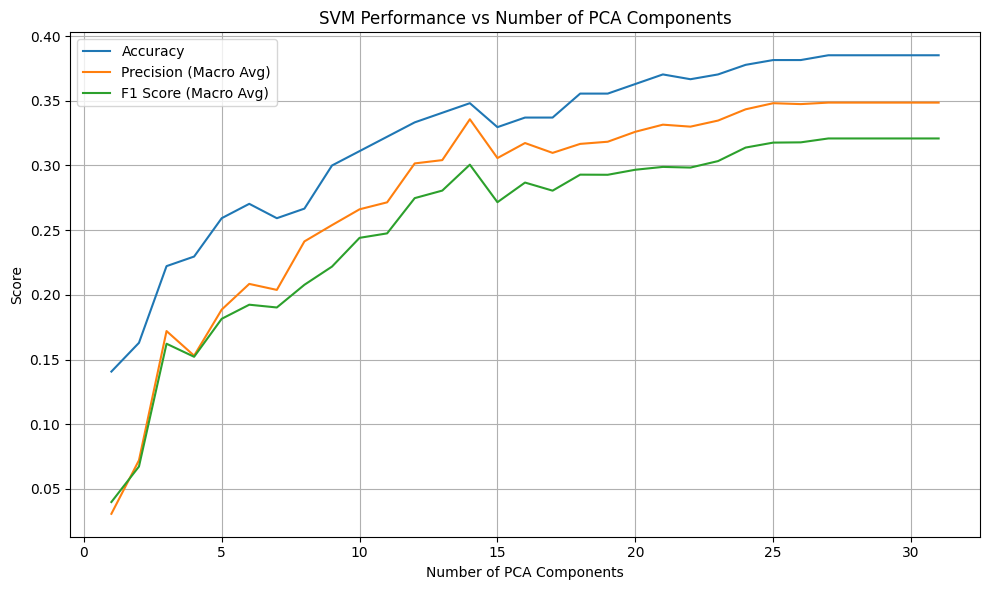

In [25]:
# Lists to store metrics
accuracies = []
precisions = []
f1_scores = []
components_range = range(1, 32)

for i in components_range:
    # Apply PCA with i components
    pca = PCA(n_components=i)
    principal_components = pca.fit_transform(X)
    pca_processed = pd.DataFrame(data=principal_components)

    # Split PCA data into train and test
    pca_X_train, pca_X_test, pca_y_train, pca_y_test = train_test_split(
        pca_processed, y_primary.values.ravel(), test_size=0.2, random_state=42
    )

    # Train the classifier
    svm_classifier = SVC(kernel='rbf', decision_function_shape='ovr')
    svm_classifier.fit(pca_X_train, pca_y_train)

    # Predict
    pca_y_pred = svm_classifier.predict(pca_X_test)

    # Store evaluation metrics
    accuracies.append(accuracy_score(pca_y_test, pca_y_pred))
    precisions.append(precision_score(pca_y_test, pca_y_pred, average='macro', zero_division=0))
    f1_scores.append(f1_score(pca_y_test, pca_y_pred, average='macro', zero_division=0))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(components_range, accuracies, label='Accuracy')
plt.plot(components_range, precisions, label='Precision (Macro Avg)')
plt.plot(components_range, f1_scores, label='F1 Score (Macro Avg)')
plt.xlabel('Number of PCA Components')
plt.ylabel('Score')
plt.title('SVM Performance vs Number of PCA Components')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
def custom_accuracy(y_pred, y_primary_test, y_secondary_test, label_encoder_primary, label_encoder_secondary):
    correct_count = 0
    for i in range(len(y_pred)):
        pred_code = y_pred[i]
        primary_code = y_primary_test.iloc[i]
        secondary_code = y_secondary_test.iloc[i]
        
        # Decode the predicted integer into a string type (using the primary encoder)
        pred_str = label_encoder_primary.inverse_transform([pred_code])[0]
        
        # Decode the true primary code into a string (also primary encoder)
        true_primary_str = label_encoder_primary.inverse_transform([primary_code])[0]
        
        # Decode the true secondary code into a string (secondary encoder!)
        true_secondary_str = label_encoder_secondary.inverse_transform([secondary_code])[0]
        
        print(f"Row {i}")
        print("  Prediction code :", pred_code, "->", pred_str)
        print("  True primary code :", primary_code, "->", true_primary_str)
        print("  True secondary code :", secondary_code, "->", true_secondary_str)
        
        # Compare as strings
        if pred_str == true_primary_str or pred_str == true_secondary_str:
            print("  => MATCH!")
            correct_count += 1
        else:
            print("  => NO MATCH")
        print()

    accuracy = correct_count / len(y_pred)
    return accuracy

SVM (PCA + Grid Search)

In [27]:
# Define pipeline
pipeline = Pipeline([
    ('pca', PCA()),
    ('svc', SVC(decision_function_shape='ovr'))
])

# Define hyperparameter grid
param_grid = {
    'pca__n_components': range(1, 32),
    'svc__C': [0.1, 1, 10, 100],
    'svc__kernel': ['linear', 'rbf'],
    'svc__gamma': ['scale', 'auto']
}

# Grid search
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='accuracy',
    cv=10,
    verbose=1,
    n_jobs=-1
)

# Run grid search
X_train, X_test, y_primary_train, y_primary_test, y_secondary_train, y_secondary_test = train_test_split(X, y_primary, y_secondary, test_size=0.2, random_state=42)
grid_search.fit(X_train, y_primary_train)

# Predict on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_primary_test, y_pred)
precision = precision_score(y_primary_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_primary_test, y_pred, average='macro', zero_division=0)

print("Best Parameters:", grid_search.best_params_)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision (macro): {precision:.4f}")
print(f"Test F1 Score (macro): {f1:.4f}")

Fitting 10 folds for each of 496 candidates, totalling 4960 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

Best Parameters: {'pca__n_components': 30, 'svc__C': 100, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}
Test Accuracy: 0.4074
Test Precision (macro): 0.3774
Test F1 Score (macro): 0.3656


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


**SVM Model (Primary and Secondary Type)**

Print weights


In [28]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score
)
import numpy as np
import pandas as pd

# Stratified 10-fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

metrics_list = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y_primary), 1):
    # Data split
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_primary_train = y_primary.iloc[train_idx]
    y_primary_test = y_primary.iloc[test_idx]
    y_secondary_test = y_secondary.iloc[test_idx]

    clf = SVC(kernel='rbf', decision_function_shape='ovr')
    clf.fit(X_train, y_primary_train)
    y_pred = clf.predict(X_test)

    custom_acc = custom_accuracy(y_pred, y_primary_test, y_secondary_test,
                                 label_encoder_primary, label_encoder_secondary)

    macro_precision = precision_score(y_primary_test, y_pred, average='macro', zero_division=0)
    macro_recall = recall_score(y_primary_test, y_pred, average='macro', zero_division=0)
    macro_f1 = f1_score(y_primary_test, y_pred, average='macro', zero_division=0)

    weighted_precision = precision_score(y_primary_test, y_pred, average='weighted', zero_division=0)
    weighted_recall = recall_score(y_primary_test, y_pred, average='weighted', zero_division=0)
    weighted_f1 = f1_score(y_primary_test, y_pred, average='weighted', zero_division=0)
    
    metrics_list.append({
        "Custom Accuracy": custom_acc,
        "Macro Precision": macro_precision,
        "Macro Recall": macro_recall,
        "Macro F1": macro_f1,
        "Weighted Precision": weighted_precision,
        "Weighted Recall": weighted_recall,
        "Weighted F1": weighted_f1
    })

    print(f"\n=== Fold {fold} ===")
    print(f"Custom Accuracy: {custom_acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_primary_test, y_pred, digits=4))
    print("Confusion Matrix:")
    print(confusion_matrix(y_primary_test, y_pred))

df_metrics = pd.DataFrame(metrics_list)
print("\n=== Cross-Validated Metric Summary (mean ± std_dev) ===")
for metric in df_metrics.columns:
    mean = df_metrics[metric].mean()
    std = df_metrics[metric].std()
    print(f"{metric}: {mean:.4f} ± {std:.4f}")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Row 0
  Prediction code : 6 -> Fire
  True primary code : Primary Typing Label    9
Name: 2, dtype: int64 -> Grass
  True secondary code : Secondary Typing Label    13
Name: 2, dtype: int64 -> Poison
  => NO MATCH

Row 1
  Prediction code : 12 -> Normal
  True primary code : Primary Typing Label    0
Name: 18, dtype: int64 -> Bug
  True secondary code : Secondary Typing Label    13
Name: 18, dtype: int64 -> Poison
  => NO MATCH

Row 2
  Prediction code : 12 -> Normal
  True primary code : Primary Typing Label    0
Name: 19, dtype: int64 -> Bug
  True secondary code : Secondary Typing Label    13
Name: 19, dtype: int64 -> Poison
  => NO MATCH

Row 3
  Prediction code : 0 -> Bug
  True primary code : Primary Typing Label    10
Name: 41, dtype: int64 -> Ground
  True secondary code : Secondary Typing Label    10
Name: 41, dtype: int64 -> Ground
  => NO MATCH

Row 4
  Prediction code : 0 -> Bug
  True primary code : Primary Typing Label    0
Name: 62, dtype: int64 -> Bug
  True secondary c

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sk


=== Fold 1 ===
Custom Accuracy: 0.3852
Classification Report:
              precision    recall  f1-score   support

           0     0.5833    0.6364    0.6087        11
           1     0.5000    0.1667    0.2500         6
           2     0.2222    0.5000    0.3077         4
           3     0.7500    0.4286    0.5455         7
           4     0.7500    0.6000    0.6667         5
           5     0.1250    0.2000    0.1538         5
           6     0.3000    0.4286    0.3529         7
           7     0.0000    0.0000    0.0000         1
           8     0.2500    0.1667    0.2000         6
           9     0.2222    0.3077    0.2581        13
          10     0.0000    0.0000    0.0000         5
          11     0.0000    0.0000    0.0000         5
          12     0.1600    0.2667    0.2000        15
          13     0.0000    0.0000    0.0000         5
          14     0.5833    0.5833    0.5833        12
          15     0.6000    0.4286    0.5000         7
          16     0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sk

Row 0
  Prediction code : 6 -> Fire
  True primary code : Primary Typing Label    6
Name: 4, dtype: int64 -> Fire
  True secondary code : Secondary Typing Label    6
Name: 4, dtype: int64 -> Fire
  => MATCH!

Row 1
  Prediction code : 14 -> Psychic
  True primary code : Primary Typing Label    0
Name: 15, dtype: int64 -> Bug
  True secondary code : Secondary Typing Label    7
Name: 15, dtype: int64 -> Flying
  => NO MATCH

Row 2
  Prediction code : 12 -> Normal
  True primary code : Primary Typing Label    12
Name: 21, dtype: int64 -> Normal
  True secondary code : Secondary Typing Label    7
Name: 21, dtype: int64 -> Flying
  => MATCH!

Row 3
  Prediction code : 12 -> Normal
  True primary code : Primary Typing Label    12
Name: 28, dtype: int64 -> Normal
  True secondary code : Secondary Typing Label    7
Name: 28, dtype: int64 -> Flying
  => MATCH!

Row 4
  Prediction code : 3 -> Electric
  True primary code : Primary Typing Label    3
Name: 35, dtype: int64 -> Electric
  True secon

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sk

Row 0
  Prediction code : 6 -> Fire
  True primary code : Primary Typing Label    9
Name: 3, dtype: int64 -> Grass
  True secondary code : Secondary Typing Label    13
Name: 3, dtype: int64 -> Poison
  => NO MATCH

Row 1
  Prediction code : 9 -> Grass
  True primary code : Primary Typing Label    17
Name: 9, dtype: int64 -> Water
  True secondary code : Secondary Typing Label    17
Name: 9, dtype: int64 -> Water
  => NO MATCH

Row 2
  Prediction code : 17 -> Water
  True primary code : Primary Typing Label    17
Name: 12, dtype: int64 -> Water
  True secondary code : Secondary Typing Label    17
Name: 12, dtype: int64 -> Water
  => MATCH!

Row 3
  Prediction code : 12 -> Normal
  True primary code : Primary Typing Label    0
Name: 13, dtype: int64 -> Bug
  True secondary code : Secondary Typing Label    0
Name: 13, dtype: int64 -> Bug
  => NO MATCH

Row 4
  Prediction code : 12 -> Normal
  True primary code : Primary Typing Label    12
Name: 26, dtype: int64 -> Normal
  True secondary 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sk

Row 0
  Prediction code : 6 -> Fire
  True primary code : Primary Typing Label    6
Name: 6, dtype: int64 -> Fire
  True secondary code : Secondary Typing Label    7
Name: 6, dtype: int64 -> Flying
  => MATCH!

Row 1
  Prediction code : 6 -> Fire
  True primary code : Primary Typing Label    6
Name: 8, dtype: int64 -> Fire
  True secondary code : Secondary Typing Label    7
Name: 8, dtype: int64 -> Flying
  => MATCH!

Row 2
  Prediction code : 0 -> Bug
  True primary code : Primary Typing Label    0
Name: 14, dtype: int64 -> Bug
  True secondary code : Secondary Typing Label    0
Name: 14, dtype: int64 -> Bug
  => MATCH!

Row 3
  Prediction code : 3 -> Electric
  True primary code : Primary Typing Label    3
Name: 37, dtype: int64 -> Electric
  True secondary code : Secondary Typing Label    14
Name: 37, dtype: int64 -> Psychic
  => MATCH!

Row 4
  Prediction code : 15 -> Rock
  True primary code : Primary Typing Label    10
Name: 39, dtype: int64 -> Ground
  True secondary code : Seco

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  


=== Fold 9 ===
Custom Accuracy: 0.4000
Classification Report:
              precision    recall  f1-score   support

           0     0.5000    0.4545    0.4762        11
           1     0.0000    0.0000    0.0000         6
           2     0.5000    0.2000    0.2857         5
           3     0.3750    0.3750    0.3750         8
           4     1.0000    0.4000    0.5714         5
           5     0.6667    0.3333    0.4444         6
           6     0.4286    0.4286    0.4286         7
           7     0.0000    0.0000    0.0000         1
           8     0.2500    0.2000    0.2222         5
           9     0.2222    0.1667    0.1905        12
          10     0.5000    0.2000    0.2857         5
          11     0.0000    0.0000    0.0000         4
          12     0.3235    0.7333    0.4490        15
          13     0.0000    0.0000    0.0000         5
          14     0.3529    0.5455    0.4286        11
          15     0.6667    0.2500    0.3636         8
          16     0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [29]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Lists to store per-fold results
accuracies = []
macro_precisions = []
macro_recalls = []
macro_f1s = []
weighted_precisions = []
weighted_recalls = []
weighted_f1s = []

# Stratified 10-fold cross-validation
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y_primary), 1):
    # Data split
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_primary_train, y_primary_test = y_primary.iloc[train_idx], y_primary.iloc[test_idx]
    y_secondary_test = y_secondary.iloc[test_idx]
    

    # Train the classifier
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_primary_train)
    
    # Predict
    y_pred = clf.predict(X_test)

    # Custom Accuracy
    custom_acc = custom_accuracy(y_pred, y_primary_test, y_secondary_test, label_encoder_primary, label_encoder_secondary)
    accuracies.append(custom_acc)

    # Precision, Recall, F1 (Macro and Weighted)
    macro_precision = precision_score(y_primary_test, y_pred, average='macro', zero_division=0)
    macro_recall = recall_score(y_primary_test, y_pred, average='macro', zero_division=0)
    macro_f1 = f1_score(y_primary_test, y_pred, average='macro', zero_division=0)

    weighted_precision = precision_score(y_primary_test, y_pred, average='weighted', zero_division=0)
    weighted_recall = recall_score(y_primary_test, y_pred, average='weighted', zero_division=0)
    weighted_f1 = f1_score(y_primary_test, y_pred, average='weighted', zero_division=0)

    # Append metrics
    macro_precisions.append(macro_precision)
    macro_recalls.append(macro_recall)
    macro_f1s.append(macro_f1)
    weighted_precisions.append(weighted_precision)
    weighted_recalls.append(weighted_recall)
    weighted_f1s.append(weighted_f1)

    # Fold summary
    print(f"\n=== Fold {fold} ===")
    print(f"Custom Accuracy: {custom_acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_primary_test, y_pred, digits=4))
    print("Confusion Matrix:")
    print(confusion_matrix(y_primary_test, y_pred))

# Calculate average and standard deviation of metrics
print("\n=== Cross-Validated Metric Summary (mean ± std_dev) ===")
print(f"Custom Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Macro Precision: {np.mean(macro_precisions):.4f} ± {np.std(macro_precisions):.4f}")
print(f"Macro Recall: {np.mean(macro_recalls):.4f} ± {np.std(macro_recalls):.4f}")
print(f"Macro F1: {np.mean(macro_f1s):.4f} ± {np.std(macro_f1s):.4f}")
print(f"Weighted Precision: {np.mean(weighted_precisions):.4f} ± {np.std(weighted_precisions):.4f}")
print(f"Weighted Recall: {np.mean(weighted_recalls):.4f} ± {np.std(weighted_recalls):.4f}")
print(f"Weighted F1: {np.mean(weighted_f1s):.4f} ± {np.std(weighted_f1s):.4f}")

Row 0
  Prediction code : 9 -> Grass
  True primary code : Primary Typing Label    9
Name: 2, dtype: int64 -> Grass
  True secondary code : Secondary Typing Label    13
Name: 2, dtype: int64 -> Poison
  => MATCH!

Row 1
  Prediction code : 0 -> Bug
  True primary code : Primary Typing Label    0
Name: 18, dtype: int64 -> Bug
  True secondary code : Secondary Typing Label    13
Name: 18, dtype: int64 -> Poison
  => MATCH!

Row 2
  Prediction code : 0 -> Bug
  True primary code : Primary Typing Label    0
Name: 19, dtype: int64 -> Bug
  True secondary code : Secondary Typing Label    13
Name: 19, dtype: int64 -> Poison
  => MATCH!

Row 3
  Prediction code : 8 -> Ghost
  True primary code : Primary Typing Label    10
Name: 41, dtype: int64 -> Ground
  True secondary code : Secondary Typing Label    10
Name: 41, dtype: int64 -> Ground
  => NO MATCH

Row 4
  Prediction code : 1 -> Dark
  True primary code : Primary Typing Label    0
Name: 62, dtype: int64 -> Bug
  True secondary code : Seco

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sk

Row 91
  Prediction code : 15 -> Rock
  True primary code : Primary Typing Label    15
Name: 932, dtype: int64 -> Rock
  True secondary code : Secondary Typing Label    2
Name: 932, dtype: int64 -> Dragon
  => MATCH!

Row 92
  Prediction code : 4 -> Fairy
  True primary code : Primary Typing Label    4
Name: 936, dtype: int64 -> Fairy
  True secondary code : Secondary Typing Label    4
Name: 936, dtype: int64 -> Fairy
  => MATCH!

Row 93
  Prediction code : 15 -> Rock
  True primary code : Primary Typing Label    16
Name: 945, dtype: int64 -> Steel
  True secondary code : Secondary Typing Label    2
Name: 945, dtype: int64 -> Dragon
  => NO MATCH

Row 94
  Prediction code : 5 -> Fighting
  True primary code : Primary Typing Label    7
Name: 961, dtype: int64 -> Flying
  True secondary code : Secondary Typing Label    2
Name: 961, dtype: int64 -> Dragon
  => NO MATCH

Row 95
  Prediction code : 13 -> Poison
  True primary code : Primary Typing Label    6
Name: 978, dtype: int64 -> Fire


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sk

Row 0
  Prediction code : 17 -> Water
  True primary code : Primary Typing Label    9
Name: 0, dtype: int64 -> Grass
  True secondary code : Secondary Typing Label    13
Name: 0, dtype: int64 -> Poison
  => NO MATCH

Row 1
  Prediction code : 6 -> Fire
  True primary code : Primary Typing Label    9
Name: 1, dtype: int64 -> Grass
  True secondary code : Secondary Typing Label    13
Name: 1, dtype: int64 -> Poison
  => NO MATCH

Row 2
  Prediction code : 7 -> Flying
  True primary code : Primary Typing Label    12
Name: 20, dtype: int64 -> Normal
  True secondary code : Secondary Typing Label    7
Name: 20, dtype: int64 -> Flying
  => MATCH!

Row 3
  Prediction code : 12 -> Normal
  True primary code : Primary Typing Label    1
Name: 25, dtype: int64 -> Dark
  True secondary code : Secondary Typing Label    12
Name: 25, dtype: int64 -> Normal
  => MATCH!

Row 4
  Prediction code : 0 -> Bug
  True primary code : Primary Typing Label    3
Name: 32, dtype: int64 -> Electric
  True secondar

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  


=== Fold 6 ===
Custom Accuracy: 0.3926
Classification Report:
              precision    recall  f1-score   support

           0     0.3333    0.3636    0.3478        11
           1     0.3333    0.3333    0.3333         6
           2     0.3333    0.4000    0.3636         5
           3     0.4444    0.5000    0.4706         8
           4     0.7500    0.5000    0.6000         6
           5     0.5000    0.3333    0.4000         6
           6     0.2222    0.2500    0.2353         8
           7     0.0000    0.0000    0.0000         1
           8     0.0000    0.0000    0.0000         5
           9     0.2143    0.2500    0.2308        12
          10     0.0000    0.0000    0.0000         5
          11     0.2500    0.2500    0.2500         4
          12     0.5714    0.5333    0.5517        15
          13     0.0000    0.0000    0.0000         5
          14     0.5714    0.3636    0.4444        11
          15     0.4545    0.6250    0.5263         8
          16     0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sk

Row 38
  Prediction code : 17 -> Water
  True primary code : Primary Typing Label    9
Name: 359, dtype: int64 -> Grass
  True secondary code : Secondary Typing Label    9
Name: 359, dtype: int64 -> Grass
  => NO MATCH

Row 39
  Prediction code : 17 -> Water
  True primary code : Primary Typing Label    6
Name: 363, dtype: int64 -> Fire
  True secondary code : Secondary Typing Label    5
Name: 363, dtype: int64 -> Fighting
  => NO MATCH

Row 40
  Prediction code : 17 -> Water
  True primary code : Primary Typing Label    17
Name: 367, dtype: int64 -> Water
  True secondary code : Secondary Typing Label    10
Name: 367, dtype: int64 -> Ground
  => MATCH!

Row 41
  Prediction code : 0 -> Bug
  True primary code : Primary Typing Label    0
Name: 376, dtype: int64 -> Bug
  True secondary code : Secondary Typing Label    0
Name: 376, dtype: int64 -> Bug
  => MATCH!

Row 42
  Prediction code : 13 -> Poison
  True primary code : Primary Typing Label    9
Name: 384, dtype: int64 -> Grass
  Tru

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sk

Row 0
  Prediction code : 9 -> Grass
  True primary code : Primary Typing Label    12
Name: 22, dtype: int64 -> Normal
  True secondary code : Secondary Typing Label    7
Name: 22, dtype: int64 -> Flying
  => NO MATCH

Row 1
  Prediction code : 6 -> Fire
  True primary code : Primary Typing Label    12
Name: 23, dtype: int64 -> Normal
  True secondary code : Secondary Typing Label    7
Name: 23, dtype: int64 -> Flying
  => NO MATCH

Row 2
  Prediction code : 1 -> Dark
  True primary code : Primary Typing Label    12
Name: 24, dtype: int64 -> Normal
  True secondary code : Secondary Typing Label    12
Name: 24, dtype: int64 -> Normal
  => NO MATCH

Row 3
  Prediction code : 5 -> Fighting
  True primary code : Primary Typing Label    13
Name: 31, dtype: int64 -> Poison
  True secondary code : Secondary Typing Label    13
Name: 31, dtype: int64 -> Poison
  => NO MATCH

Row 4
  Prediction code : 9 -> Grass
  True primary code : Primary Typing Label    13
Name: 44, dtype: int64 -> Poison
  

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sk


=== Fold 9 ===
Custom Accuracy: 0.4148
Classification Report:
              precision    recall  f1-score   support

           0     0.2500    0.2727    0.2609        11
           1     0.2222    0.3333    0.2667         6
           2     1.0000    0.8000    0.8889         5
           3     0.3000    0.3750    0.3333         8
           4     0.4286    0.6000    0.5000         5
           5     0.6250    0.8333    0.7143         6
           6     0.2500    0.2857    0.2667         7
           7     0.0000    0.0000    0.0000         1
           8     0.5714    0.8000    0.6667         5
           9     0.3333    0.3333    0.3333        12
          10     0.2500    0.2000    0.2222         5
          11     0.0000    0.0000    0.0000         4
          12     0.3846    0.3333    0.3571        15
          13     0.3333    0.2000    0.2500         5
          14     0.6667    0.5455    0.6000        11
          15     0.6000    0.3750    0.4615         8
          16     0

In [30]:
rf_accuracy = []
rf_custom_accuracy = []
rf_macro_precision = []
rf_macro_recall = []
rf_macro_f1 = []
rf_weighted_precision = []
rf_weighted_recall = []
rf_weighted_f1 = []

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


for fold, (train_idx, test_idx) in enumerate(skf.split(X, y_primary), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_primary.iloc[train_idx], y_primary.iloc[test_idx]
    sec_test = y_secondary.iloc[test_idx]

    # Train Random Forest
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_clf.fit(X_train, y_train)
    y_pred = rf_clf.predict(X_test)

    # Standard accuracy
    acc = accuracy_score(y_test, y_pred)
    rf_accuracy.append(acc)

    # Custom accuracy (primary or secondary match)
    custom_acc = custom_accuracy(y_pred, y_test, sec_test, label_encoder_primary, label_encoder_secondary)
    rf_custom_accuracy.append(custom_acc)

    # Macro
    macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(
        y_test, y_pred, average='macro', zero_division=0
    )
    rf_macro_precision.append(macro_p)
    rf_macro_recall.append(macro_r)
    rf_macro_f1.append(macro_f)


    weighted_p, weighted_r, weighted_f, _ = precision_recall_fscore_support(
        y_test, y_pred, average='weighted', zero_division=0
    )
    rf_weighted_precision.append(weighted_p)
    rf_weighted_recall.append(weighted_r)
    rf_weighted_f1.append(weighted_f)

    print(f"Fold {fold}: Accuracy = {acc:.4f}, Custom Accuracy = {custom_acc:.4f}")

# Final summary
print("\n=== Random Forest Cross-Validated Metrics (Mean ± Std) ===")
print(f"Standard Accuracy:               {mean_std(rf_accuracy)}")
print(f"Custom Accuracy (Primary|Sec):  {mean_std(rf_custom_accuracy)}")
print(f"Macro Precision:                {mean_std(rf_macro_precision)}")
print(f"Macro Recall:                   {mean_std(rf_macro_recall)}")
print(f"Macro F1 Score:                 {mean_std(rf_macro_f1)}")
print(f"Weighted Precision:             {mean_std(rf_weighted_precision)}")
print(f"Weighted Recall:                {mean_std(rf_weighted_recall)}")
print(f"Weighted F1 Score:              {mean_std(rf_weighted_f1)}")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skl

Row 0
  Prediction code : 17 -> Water
  True primary code : Primary Typing Label    9
Name: 2, dtype: int64 -> Grass
  True secondary code : Secondary Typing Label    13
Name: 2, dtype: int64 -> Poison
  => NO MATCH

Row 1
  Prediction code : 0 -> Bug
  True primary code : Primary Typing Label    0
Name: 18, dtype: int64 -> Bug
  True secondary code : Secondary Typing Label    13
Name: 18, dtype: int64 -> Poison
  => MATCH!

Row 2
  Prediction code : 0 -> Bug
  True primary code : Primary Typing Label    0
Name: 19, dtype: int64 -> Bug
  True secondary code : Secondary Typing Label    13
Name: 19, dtype: int64 -> Poison
  => MATCH!

Row 3
  Prediction code : 8 -> Ghost
  True primary code : Primary Typing Label    10
Name: 41, dtype: int64 -> Ground
  True secondary code : Secondary Typing Label    10
Name: 41, dtype: int64 -> Ground
  => NO MATCH

Row 4
  Prediction code : 8 -> Ghost
  True primary code : Primary Typing Label    0
Name: 62, dtype: int64 -> Bug
  True secondary code : 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skl

Row 0
  Prediction code : 6 -> Fire
  True primary code : Primary Typing Label    6
Name: 4, dtype: int64 -> Fire
  True secondary code : Secondary Typing Label    6
Name: 4, dtype: int64 -> Fire
  => MATCH!

Row 1
  Prediction code : 0 -> Bug
  True primary code : Primary Typing Label    0
Name: 15, dtype: int64 -> Bug
  True secondary code : Secondary Typing Label    7
Name: 15, dtype: int64 -> Flying
  => MATCH!

Row 2
  Prediction code : 12 -> Normal
  True primary code : Primary Typing Label    12
Name: 21, dtype: int64 -> Normal
  True secondary code : Secondary Typing Label    7
Name: 21, dtype: int64 -> Flying
  => MATCH!

Row 3
  Prediction code : 12 -> Normal
  True primary code : Primary Typing Label    12
Name: 28, dtype: int64 -> Normal
  True secondary code : Secondary Typing Label    7
Name: 28, dtype: int64 -> Flying
  => MATCH!

Row 4
  Prediction code : 3 -> Electric
  True primary code : Primary Typing Label    3
Name: 35, dtype: int64 -> Electric
  True secondary co

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skl

Row 0
  Prediction code : 17 -> Water
  True primary code : Primary Typing Label    9
Name: 0, dtype: int64 -> Grass
  True secondary code : Secondary Typing Label    13
Name: 0, dtype: int64 -> Poison
  => NO MATCH

Row 1
  Prediction code : 6 -> Fire
  True primary code : Primary Typing Label    9
Name: 1, dtype: int64 -> Grass
  True secondary code : Secondary Typing Label    13
Name: 1, dtype: int64 -> Poison
  => NO MATCH

Row 2
  Prediction code : 12 -> Normal
  True primary code : Primary Typing Label    12
Name: 20, dtype: int64 -> Normal
  True secondary code : Secondary Typing Label    7
Name: 20, dtype: int64 -> Flying
  => MATCH!

Row 3
  Prediction code : 12 -> Normal
  True primary code : Primary Typing Label    1
Name: 25, dtype: int64 -> Dark
  True secondary code : Secondary Typing Label    12
Name: 25, dtype: int64 -> Normal
  => MATCH!

Row 4
  Prediction code : 3 -> Electric
  True primary code : Primary Typing Label    3
Name: 32, dtype: int64 -> Electric
  True se

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skl

Fold 5: Accuracy = 0.5037, Custom Accuracy = 0.5556


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skl

Row 0
  Prediction code : 6 -> Fire
  True primary code : Primary Typing Label    6
Name: 5, dtype: int64 -> Fire
  True secondary code : Secondary Typing Label    6
Name: 5, dtype: int64 -> Fire
  => MATCH!

Row 1
  Prediction code : 0 -> Bug
  True primary code : Primary Typing Label    0
Name: 17, dtype: int64 -> Bug
  True secondary code : Secondary Typing Label    13
Name: 17, dtype: int64 -> Poison
  => MATCH!

Row 2
  Prediction code : 3 -> Electric
  True primary code : Primary Typing Label    3
Name: 33, dtype: int64 -> Electric
  True secondary code : Secondary Typing Label    3
Name: 33, dtype: int64 -> Electric
  => MATCH!

Row 3
  Prediction code : 3 -> Electric
  True primary code : Primary Typing Label    3
Name: 36, dtype: int64 -> Electric
  True secondary code : Secondary Typing Label    3
Name: 36, dtype: int64 -> Electric
  => MATCH!

Row 4
  Prediction code : 12 -> Normal
  True primary code : Primary Typing Label    13
Name: 57, dtype: int64 -> Poison
  True secon

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skl

Fold 8: Accuracy = 0.4815, Custom Accuracy = 0.5111


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skl

Row 0
  Prediction code : 6 -> Fire
  True primary code : Primary Typing Label    12
Name: 22, dtype: int64 -> Normal
  True secondary code : Secondary Typing Label    7
Name: 22, dtype: int64 -> Flying
  => NO MATCH

Row 1
  Prediction code : 6 -> Fire
  True primary code : Primary Typing Label    12
Name: 23, dtype: int64 -> Normal
  True secondary code : Secondary Typing Label    7
Name: 23, dtype: int64 -> Flying
  => NO MATCH

Row 2
  Prediction code : 1 -> Dark
  True primary code : Primary Typing Label    12
Name: 24, dtype: int64 -> Normal
  True secondary code : Secondary Typing Label    12
Name: 24, dtype: int64 -> Normal
  => NO MATCH

Row 3
  Prediction code : 12 -> Normal
  True primary code : Primary Typing Label    13
Name: 31, dtype: int64 -> Poison
  True secondary code : Secondary Typing Label    13
Name: 31, dtype: int64 -> Poison
  => NO MATCH

Row 4
  Prediction code : 9 -> Grass
  True primary code : Primary Typing Label    13
Name: 44, dtype: int64 -> Poison
  Tr

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sk

MLP SCIKIT LEARN Model


In [33]:
mlp_accuracy = []
mlp_custom_accuracy = []
mlp_macro_precision = []
mlp_macro_recall = []
mlp_macro_f1 = []
mlp_weighted_precision = []
mlp_weighted_recall = []
mlp_weighted_f1 = []

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y_primary), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train_primary = y_primary.iloc[train_idx]
    y_test_primary = y_primary.iloc[test_idx]
    y_test_secondary = y_secondary.iloc[test_idx]
    
    mlp_clf = MLPClassifier(hidden_layer_sizes=(100,), 
                            activation='relu',
                            solver='adam',
                            max_iter=300,
                            random_state=42)
    mlp_clf.fit(X_train, y_train_primary)
    y_pred = mlp_clf.predict(X_test)


    acc = accuracy_score(y_test_primary, y_pred)
    mlp_accuracy.append(acc)

    acc_custom = custom_accuracy(
        y_pred, y_test_primary, y_test_secondary,
        label_encoder_primary, label_encoder_secondary
    )
    mlp_custom_accuracy.append(acc_custom)

    macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(
        y_test_primary, y_pred, average='macro', zero_division=0
    )
    mlp_macro_precision.append(macro_p)
    mlp_macro_recall.append(macro_r)
    mlp_macro_f1.append(macro_f)
    
    weighted_p, weighted_r, weighted_f, _ = precision_recall_fscore_support(
        y_test_primary, y_pred, average='weighted', zero_division=0
    )
    mlp_weighted_precision.append(weighted_p)
    mlp_weighted_recall.append(weighted_r)
    mlp_weighted_f1.append(weighted_f)

    print(f"Fold {fold}: Accuracy = {acc:.4f}, Custom Accuracy = {acc_custom:.4f}")

print("\n=== MLP Cross-Validated Metrics (Mean ± Std) ===")
print(f"Standard Accuracy:               {mean_std(mlp_accuracy)}")
print(f"Custom Accuracy (Primary|Sec):  {mean_std(mlp_custom_accuracy)}")
print(f"Macro Precision:                {mean_std(mlp_macro_precision)}")
print(f"Macro Recall:                   {mean_std(mlp_macro_recall)}")
print(f"Macro F1 Score:                 {mean_std(mlp_macro_f1)}")
print(f"Weighted Precision:             {mean_std(mlp_weighted_precision)}")
print(f"Weighted Recall:                {mean_std(mlp_weighted_recall)}")
print(f"Weighted F1 Score:              {mean_std(mlp_weighted_f1)}")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing

Row 0
  Prediction code : 17 -> Water
  True primary code : Primary Typing Label    9
Name: 2, dtype: int64 -> Grass
  True secondary code : Secondary Typing Label    13
Name: 2, dtype: int64 -> Poison
  => NO MATCH

Row 1
  Prediction code : 0 -> Bug
  True primary code : Primary Typing Label    0
Name: 18, dtype: int64 -> Bug
  True secondary code : Secondary Typing Label    13
Name: 18, dtype: int64 -> Poison
  => MATCH!

Row 2
  Prediction code : 10 -> Ground
  True primary code : Primary Typing Label    0
Name: 19, dtype: int64 -> Bug
  True secondary code : Secondary Typing Label    13
Name: 19, dtype: int64 -> Poison
  => NO MATCH

Row 3
  Prediction code : 10 -> Ground
  True primary code : Primary Typing Label    10
Name: 41, dtype: int64 -> Ground
  True secondary code : Secondary Typing Label    10
Name: 41, dtype: int64 -> Ground
  => MATCH!

Row 4
  Prediction code : 9 -> Grass
  True primary code : Primary Typing Label    0
Name: 62, dtype: int64 -> Bug
  True secondary c

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: Da

Row 0
  Prediction code : 9 -> Grass
  True primary code : Primary Typing Label    6
Name: 7, dtype: int64 -> Fire
  True secondary code : Secondary Typing Label    2
Name: 7, dtype: int64 -> Dragon
  => NO MATCH

Row 1
  Prediction code : 9 -> Grass
  True primary code : Primary Typing Label    17
Name: 10, dtype: int64 -> Water
  True secondary code : Secondary Typing Label    17
Name: 10, dtype: int64 -> Water
  => NO MATCH

Row 2
  Prediction code : 9 -> Grass
  True primary code : Primary Typing Label    17
Name: 11, dtype: int64 -> Water
  True secondary code : Secondary Typing Label    17
Name: 11, dtype: int64 -> Water
  => NO MATCH

Row 3
  Prediction code : 17 -> Water
  True primary code : Primary Typing Label    12
Name: 29, dtype: int64 -> Normal
  True secondary code : Secondary Typing Label    7
Name: 29, dtype: int64 -> Flying
  => NO MATCH

Row 4
  Prediction code : 6 -> Fire
  True primary code : Primary Typing Label    13
Name: 48, dtype: int64 -> Poison
  True secon

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: Da

Row 0
  Prediction code : 6 -> Fire
  True primary code : Primary Typing Label    6
Name: 4, dtype: int64 -> Fire
  True secondary code : Secondary Typing Label    6
Name: 4, dtype: int64 -> Fire
  => MATCH!

Row 1
  Prediction code : 0 -> Bug
  True primary code : Primary Typing Label    0
Name: 15, dtype: int64 -> Bug
  True secondary code : Secondary Typing Label    7
Name: 15, dtype: int64 -> Flying
  => MATCH!

Row 2
  Prediction code : 12 -> Normal
  True primary code : Primary Typing Label    12
Name: 21, dtype: int64 -> Normal
  True secondary code : Secondary Typing Label    7
Name: 21, dtype: int64 -> Flying
  => MATCH!

Row 3
  Prediction code : 12 -> Normal
  True primary code : Primary Typing Label    12
Name: 28, dtype: int64 -> Normal
  True secondary code : Secondary Typing Label    7
Name: 28, dtype: int64 -> Flying
  => MATCH!

Row 4
  Prediction code : 3 -> Electric
  True primary code : Primary Typing Label    3
Name: 35, dtype: int64 -> Electric
  True secondary co

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: Da

Row 0
  Prediction code : 17 -> Water
  True primary code : Primary Typing Label    9
Name: 0, dtype: int64 -> Grass
  True secondary code : Secondary Typing Label    13
Name: 0, dtype: int64 -> Poison
  => NO MATCH

Row 1
  Prediction code : 9 -> Grass
  True primary code : Primary Typing Label    9
Name: 1, dtype: int64 -> Grass
  True secondary code : Secondary Typing Label    13
Name: 1, dtype: int64 -> Poison
  => MATCH!

Row 2
  Prediction code : 12 -> Normal
  True primary code : Primary Typing Label    12
Name: 20, dtype: int64 -> Normal
  True secondary code : Secondary Typing Label    7
Name: 20, dtype: int64 -> Flying
  => MATCH!

Row 3
  Prediction code : 12 -> Normal
  True primary code : Primary Typing Label    1
Name: 25, dtype: int64 -> Dark
  True secondary code : Secondary Typing Label    12
Name: 25, dtype: int64 -> Normal
  => MATCH!

Row 4
  Prediction code : 3 -> Electric
  True primary code : Primary Typing Label    3
Name: 32, dtype: int64 -> Electric
  True sec

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: Da

Row 0
  Prediction code : 9 -> Grass
  True primary code : Primary Typing Label    9
Name: 3, dtype: int64 -> Grass
  True secondary code : Secondary Typing Label    13
Name: 3, dtype: int64 -> Poison
  => MATCH!

Row 1
  Prediction code : 9 -> Grass
  True primary code : Primary Typing Label    17
Name: 9, dtype: int64 -> Water
  True secondary code : Secondary Typing Label    17
Name: 9, dtype: int64 -> Water
  => NO MATCH

Row 2
  Prediction code : 9 -> Grass
  True primary code : Primary Typing Label    17
Name: 12, dtype: int64 -> Water
  True secondary code : Secondary Typing Label    17
Name: 12, dtype: int64 -> Water
  => NO MATCH

Row 3
  Prediction code : 17 -> Water
  True primary code : Primary Typing Label    0
Name: 13, dtype: int64 -> Bug
  True secondary code : Secondary Typing Label    0
Name: 13, dtype: int64 -> Bug
  => NO MATCH

Row 4
  Prediction code : 1 -> Dark
  True primary code : Primary Typing Label    12
Name: 26, dtype: int64 -> Normal
  True secondary code

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: Da

Row 0
  Prediction code : 6 -> Fire
  True primary code : Primary Typing Label    6
Name: 5, dtype: int64 -> Fire
  True secondary code : Secondary Typing Label    6
Name: 5, dtype: int64 -> Fire
  => MATCH!

Row 1
  Prediction code : 0 -> Bug
  True primary code : Primary Typing Label    0
Name: 17, dtype: int64 -> Bug
  True secondary code : Secondary Typing Label    13
Name: 17, dtype: int64 -> Poison
  => MATCH!

Row 2
  Prediction code : 3 -> Electric
  True primary code : Primary Typing Label    3
Name: 33, dtype: int64 -> Electric
  True secondary code : Secondary Typing Label    3
Name: 33, dtype: int64 -> Electric
  => MATCH!

Row 3
  Prediction code : 3 -> Electric
  True primary code : Primary Typing Label    3
Name: 36, dtype: int64 -> Electric
  True secondary code : Secondary Typing Label    3
Name: 36, dtype: int64 -> Electric
  => MATCH!

Row 4
  Prediction code : 12 -> Normal
  True primary code : Primary Typing Label    13
Name: 57, dtype: int64 -> Poison
  True secon

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: Da

Row 0
  Prediction code : 6 -> Fire
  True primary code : Primary Typing Label    6
Name: 6, dtype: int64 -> Fire
  True secondary code : Secondary Typing Label    7
Name: 6, dtype: int64 -> Flying
  => MATCH!

Row 1
  Prediction code : 6 -> Fire
  True primary code : Primary Typing Label    6
Name: 8, dtype: int64 -> Fire
  True secondary code : Secondary Typing Label    7
Name: 8, dtype: int64 -> Flying
  => MATCH!

Row 2
  Prediction code : 0 -> Bug
  True primary code : Primary Typing Label    0
Name: 14, dtype: int64 -> Bug
  True secondary code : Secondary Typing Label    0
Name: 14, dtype: int64 -> Bug
  => MATCH!

Row 3
  Prediction code : 3 -> Electric
  True primary code : Primary Typing Label    3
Name: 37, dtype: int64 -> Electric
  True secondary code : Secondary Typing Label    14
Name: 37, dtype: int64 -> Psychic
  => MATCH!

Row 4
  Prediction code : 0 -> Bug
  True primary code : Primary Typing Label    10
Name: 39, dtype: int64 -> Ground
  True secondary code : Second

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: Da

Row 0
  Prediction code : 10 -> Ground
  True primary code : Primary Typing Label    11
Name: 40, dtype: int64 -> Ice
  True secondary code : Secondary Typing Label    16
Name: 40, dtype: int64 -> Steel
  => NO MATCH

Row 1
  Prediction code : 12 -> Normal
  True primary code : Primary Typing Label    13
Name: 45, dtype: int64 -> Poison
  True secondary code : Secondary Typing Label    10
Name: 45, dtype: int64 -> Ground
  => NO MATCH

Row 2
  Prediction code : 12 -> Normal
  True primary code : Primary Typing Label    12
Name: 55, dtype: int64 -> Normal
  True secondary code : Secondary Typing Label    4
Name: 55, dtype: int64 -> Fairy
  => MATCH!

Row 3
  Prediction code : 17 -> Water
  True primary code : Primary Typing Label    10
Name: 67, dtype: int64 -> Ground
  True secondary code : Secondary Typing Label    16
Name: 67, dtype: int64 -> Steel
  => NO MATCH

Row 4
  Prediction code : 1 -> Dark
  True primary code : Primary Typing Label    12
Name: 73, dtype: int64 -> Normal
  Tr

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: Da

Row 0
  Prediction code : 9 -> Grass
  True primary code : Primary Typing Label    12
Name: 22, dtype: int64 -> Normal
  True secondary code : Secondary Typing Label    7
Name: 22, dtype: int64 -> Flying
  => NO MATCH

Row 1
  Prediction code : 3 -> Electric
  True primary code : Primary Typing Label    12
Name: 23, dtype: int64 -> Normal
  True secondary code : Secondary Typing Label    7
Name: 23, dtype: int64 -> Flying
  => NO MATCH

Row 2
  Prediction code : 12 -> Normal
  True primary code : Primary Typing Label    12
Name: 24, dtype: int64 -> Normal
  True secondary code : Secondary Typing Label    12
Name: 24, dtype: int64 -> Normal
  => MATCH!

Row 3
  Prediction code : 5 -> Fighting
  True primary code : Primary Typing Label    13
Name: 31, dtype: int64 -> Poison
  True secondary code : Secondary Typing Label    13
Name: 31, dtype: int64 -> Poison
  => NO MATCH

Row 4
  Prediction code : 13 -> Poison
  True primary code : Primary Typing Label    13
Name: 44, dtype: int64 -> Po

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: Da

KNN

In [34]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracy_list = []
custom_accuracy_list = []
macro_precision_list = []
macro_recall_list = []
macro_f1_list = []
weighted_precision_list = []
weighted_recall_list = []
weighted_f1_list = []

param_grid = {
    'pca__n_components': [0.85, 0.9, 0.95],
    'classifier__n_neighbors': [1, 3, 5, 7],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski']
}

def mean_std(values):
    return f"{np.mean(values):.4f} ± {np.std(values):.4f}"


for fold, (train_idx, test_idx) in enumerate(skf.split(X, y_primary), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_primary.iloc[train_idx], y_primary.iloc[test_idx]
    sec_test = y_secondary.iloc[test_idx]

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('classifier', KNeighborsClassifier())
    ])

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='accuracy',
        cv=5,
        n_jobs=-1,
        verbose=0
    )
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)

    acc_primary = accuracy_score(y_test, y_pred)
    accuracy_list.append(acc_primary)

    acc_custom = np.mean([
        (pred == primary or pred == secondary)
        for pred, primary, secondary in zip(y_pred, y_test, sec_test)
    ])
    custom_accuracy_list.append(acc_custom)

    macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(
        y_test, y_pred, average='macro', zero_division=0
    )
    macro_precision_list.append(macro_p)
    macro_recall_list.append(macro_r)
    macro_f1_list.append(macro_f)

    weighted_p, weighted_r, weighted_f, _ = precision_recall_fscore_support(
        y_test, y_pred, average='weighted', zero_division=0
    )
    weighted_precision_list.append(weighted_p)
    weighted_recall_list.append(weighted_r)
    weighted_f1_list.append(weighted_f)

    print(f"Fold {fold}: Accuracy = {acc_primary:.4f}, Custom Accuracy = {acc_custom:.4f}")

print("\n=== Cross-Validated Metrics (Mean ± Std) ===")
print(f"Standard Accuracy:               {mean_std(accuracy_list)}")
print(f"Custom Accuracy (Primary|Sec):  {mean_std(custom_accuracy_list)}")
print(f"Macro Precision:                {mean_std(macro_precision_list)}")
print(f"Macro Recall:                   {mean_std(macro_recall_list)}")
print(f"Macro F1 Score:                 {mean_std(macro_f1_list)}")
print(f"Weighted Precision:             {mean_std(weighted_precision_list)}")
print(f"Weighted Recall:                {mean_std(weighted_recall_list)}")
print(f"Weighted F1 Score:              {mean_std(weighted_f1_list)}")




/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighb

Fold 1: Accuracy = 0.3778, Custom Accuracy = 0.0000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighb

Fold 2: Accuracy = 0.3778, Custom Accuracy = 0.0000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighb

Fold 3: Accuracy = 0.3778, Custom Accuracy = 0.0000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighb

Fold 4: Accuracy = 0.3926, Custom Accuracy = 0.0000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighb

Fold 5: Accuracy = 0.4000, Custom Accuracy = 0.0000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighb

Fold 6: Accuracy = 0.3704, Custom Accuracy = 0.0000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighb

Fold 7: Accuracy = 0.3111, Custom Accuracy = 0.0000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighb

Fold 8: Accuracy = 0.3556, Custom Accuracy = 0.0000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighb

Fold 9: Accuracy = 0.3037, Custom Accuracy = 0.0000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighb

Fold 10: Accuracy = 0.3778, Custom Accuracy = 0.0000

=== Cross-Validated Metrics (Mean ± Std) ===
Standard Accuracy:               0.3644 ± 0.0307
Custom Accuracy (Primary|Sec):  0.0000 ± 0.0000
Macro Precision:                0.3463 ± 0.0304
Macro Recall:                   0.3305 ± 0.0283
Macro F1 Score:                 0.3283 ± 0.0271
Weighted Precision:             0.3771 ± 0.0303
Weighted Recall:                0.3644 ± 0.0307
Weighted F1 Score:              0.3616 ± 0.0283


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighb